In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interest rate

In [2]:
stir = pd.read_csv('var/short_term_int_rate_q.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['date'] = pd.to_datetime(stir['TIME'])

#### inflation rate

In [5]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()
ir = ir[:-9]
ir = [float(ir[i]) for i in range(len(ir))]
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

In [6]:
ir = ir.iloc[:-3, :].copy()

In [7]:
ir['date'] = ir['TIME'].map(lambda x: pd.Period(x,'Q'))

In [8]:
ir = ir[['date', 'Value']].copy()

In [9]:
ir['Value'] = ir['Value'].astype(float)

In [10]:
ir['date'] = ir['date'].astype(str)

In [11]:
quarters = pd.unique(ir['date']).tolist()

In [12]:
g = ir.groupby('date')['Value']

In [13]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [14]:
ir = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [15]:
gdp = pd.read_csv('var/gdp_m_q.csv')

In [16]:
gdp = gdp[
    gdp['Subject']=='National Accounts > GDP by Expenditure > Constant Prices > Gross Domestic Product - Total'
].copy()

In [17]:
gdp = gdp[gdp['Measure']=='Level, rate or national currency, s.a.'].copy()

In [18]:
gdp = gdp[gdp['FREQUENCY']=='Q'].copy()

In [19]:
gdp = gdp[['Subject', 'Measure', 'FREQUENCY', 'TIME', 'Time', 'Unit Code', 'Value']].copy()

In [20]:
gdp = gdp.reset_index(drop=True)

In [21]:
gdp = gdp[['TIME', 'Value']].copy()

In [22]:
gdp['date'] = pd.to_datetime(gdp['TIME']).tolist()

#### Unemployment

In [23]:
ur = pd.read_csv('var/unemployment_rate_q.csv')

In [24]:
ur = ur[ur['LOCATION']=='USA'].copy()

In [25]:
ur = ur[['TIME', 'Value']].copy()

In [26]:
ur['date'] = pd.to_datetime(ur['TIME'])

#### Make full DF

In [27]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()

In [28]:
stir.index = stir['date']
stir = stir[['Value']].copy()

In [29]:
ir.index = ir['date']
ir = ir[['Value']].copy()

In [30]:
ur.index = ur['date']
ur = ur[['Value']].copy()

In [31]:
df_var_t = pd.concat([gdp, stir, ir, ur], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr', 'umpr']

## Stationarity part

Results of Dickey-Fuller Test:
Test Statistic                   1.145867
p-value                          0.995590
#Lags Used                       2.000000
Number of Observations Used    206.000000
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
Critical Value (1%)             -3.462499
dtype: float64


Results of KPSS Test:
Test Statistic            1.400572
p-value                   0.010000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


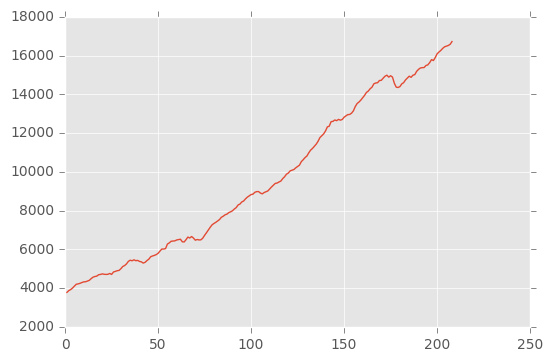

In [32]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.763228
p-value                          0.398865
#Lags Used                       7.000000
Number of Observations Used    201.000000
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
Critical Value (1%)             -3.463309
dtype: float64


Results of KPSS Test:
Test Statistic            0.796102
p-value                   0.010000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


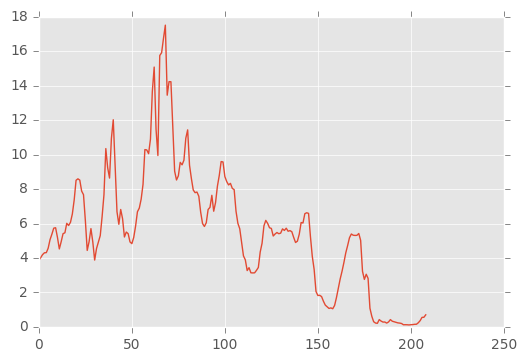

In [33]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.549506
p-value                          0.508895
#Lags Used                      12.000000
Number of Observations Used    196.000000
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
Critical Value (1%)             -3.464161
dtype: float64


Results of KPSS Test:
Test Statistic            0.623364
p-value                   0.020512
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


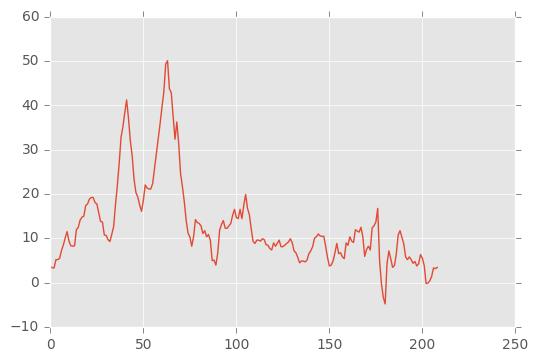

In [34]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.085297
p-value                          0.027661
#Lags Used                       9.000000
Number of Observations Used    199.000000
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
Critical Value (1%)             -3.463645
dtype: float64


Results of KPSS Test:
Test Statistic            0.144519
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


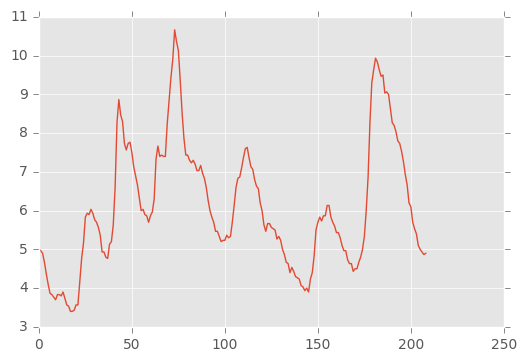

In [35]:
test_stationarity(df_var_t['umpr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                -6.704428e+00
p-value                        3.816825e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.060000e+02
Critical Value (5%)           -2.875675e+00
Critical Value (10%)          -2.574304e+00
Critical Value (1%)           -3.462499e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.302797
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


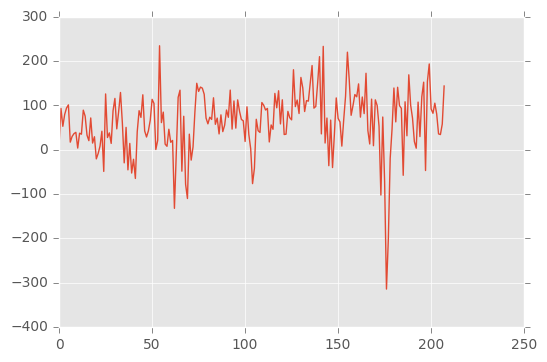

In [36]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -5.903223e+00
p-value                        2.746714e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.010000e+02
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
Critical Value (1%)           -3.463309e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.122618
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


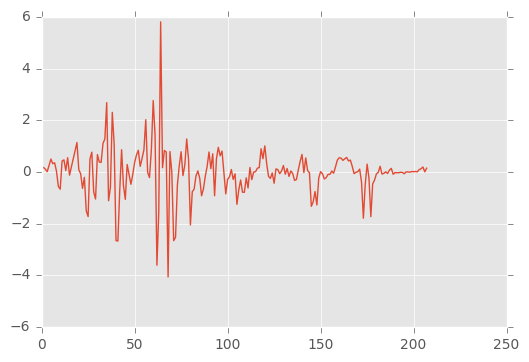

In [37]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.488352
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    192.000000
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
Critical Value (1%)             -3.464875
dtype: float64


Results of KPSS Test:
Test Statistic            0.119528
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


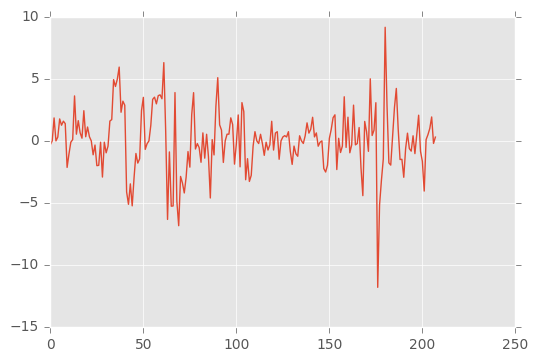

In [38]:
test_stationarity(diff_series(df_var_t['infr']))

Results of Dickey-Fuller Test:
Test Statistic                  -4.944709
p-value                          0.000029
#Lags Used                      11.000000
Number of Observations Used    196.000000
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
Critical Value (1%)             -3.464161
dtype: float64


Results of KPSS Test:
Test Statistic            0.062779
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


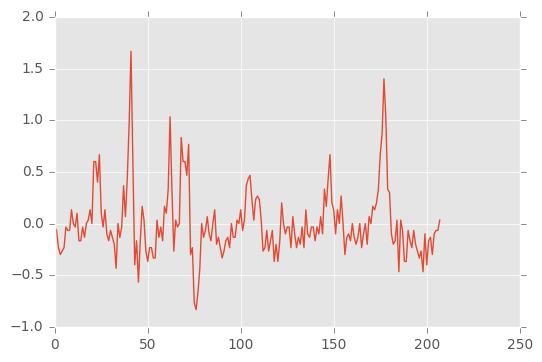

In [39]:
test_stationarity(diff_series(df_var_t['umpr']))

In [40]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [41]:
STEPS = 8
LAG = 4
N_FEAT = 4

In [42]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [43]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [44]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mse': 0.21120528865381649, 'rmse': 0.45957076566489352, 'mae': 0.37599562640761908}
{'mse': 4.5040649381412132, 'rmse': 2.1222782423945294, 'mae': 1.3701020922493079}
{'mse': 1365.1878404155964, 'rmse': 36.948448416890209, 'mae': 26.715414984475295}
{'mse': 0.014013636565621521, 'rmse': 0.11837920664382542, 'mae': 0.094101391251037433}


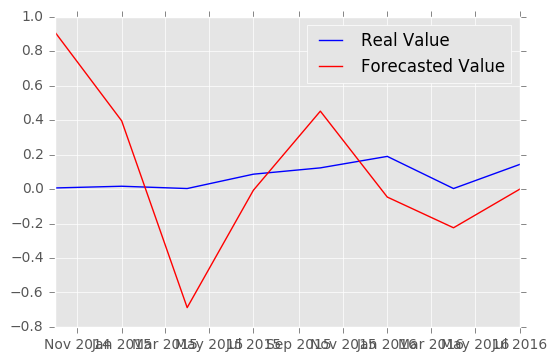

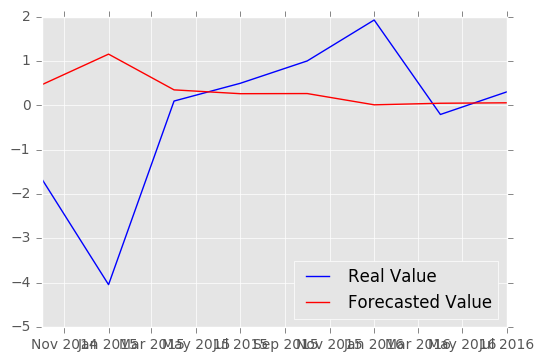

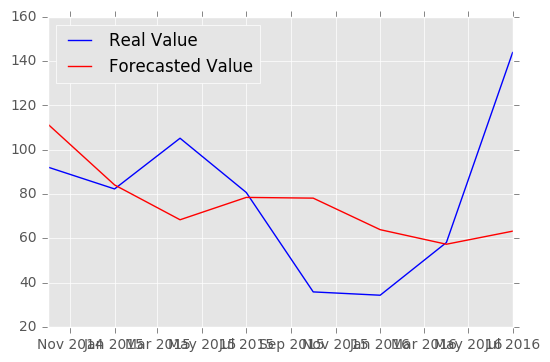

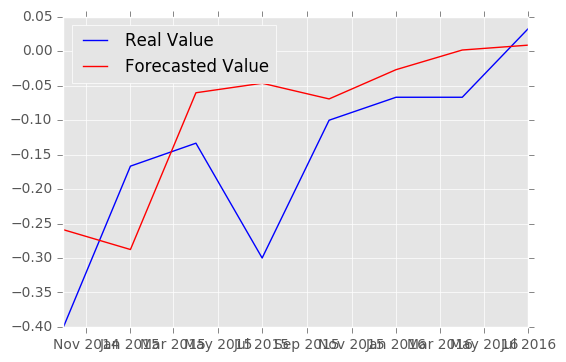

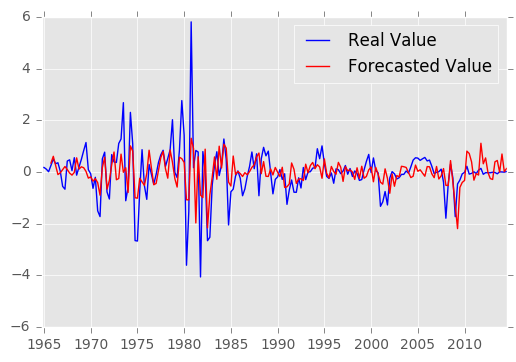

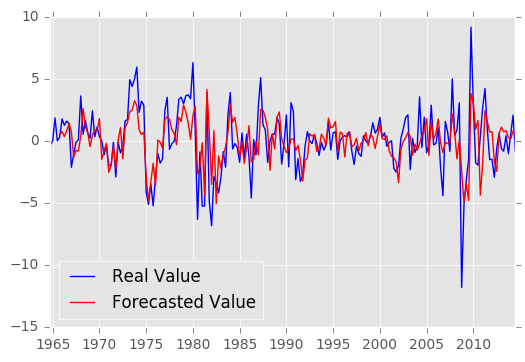

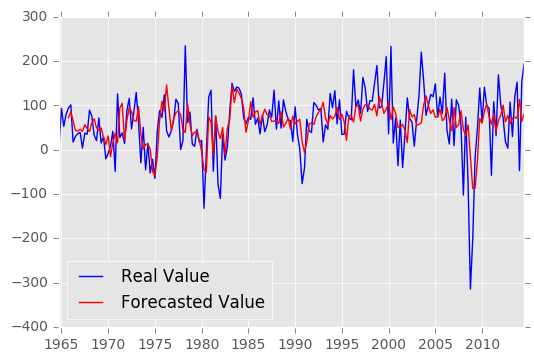

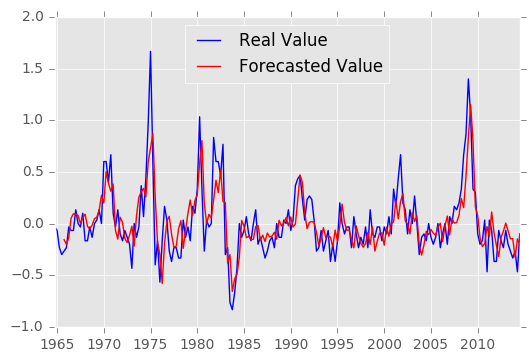

In [45]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['out']['umpr'], test['umpr'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])
plot_compar(var_result['in']['umpr'], train['umpr'])

{'mse': 0.53892868911895098, 'rmse': 0.73411762621459442, 'mae': 0.66324374788592011}
{'mse': 35.17764634302803, 'rmse': 5.9310746364405187, 'mae': 5.6605716153548871}
{'mse': 1065.6992924405749, 'rmse': 32.64505004500031, 'mae': 29.187001638291122}
{'mse': 0.11461262494363673, 'rmse': 0.33854486400422135, 'mae': 0.29318188949205992}


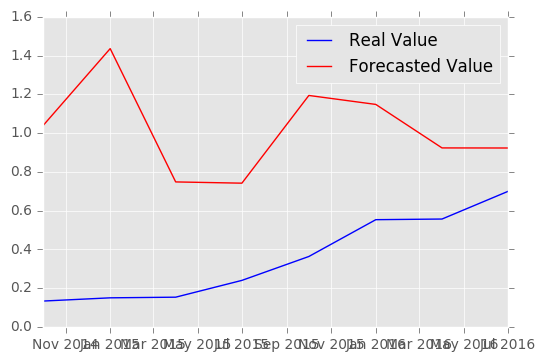

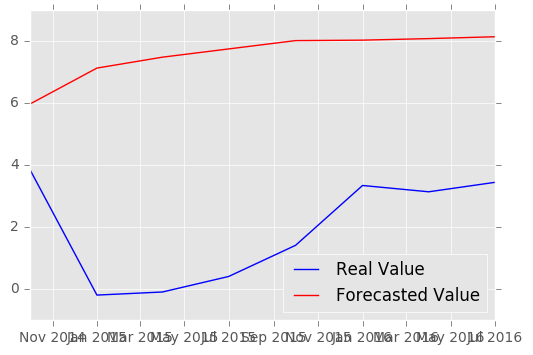

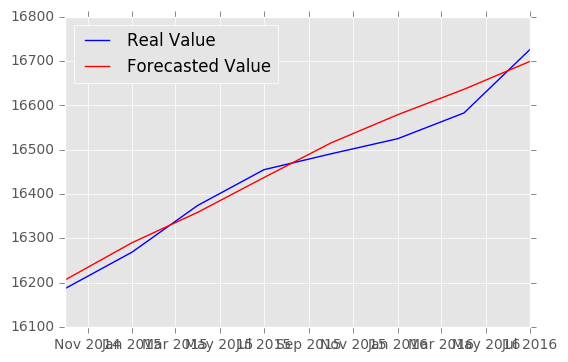

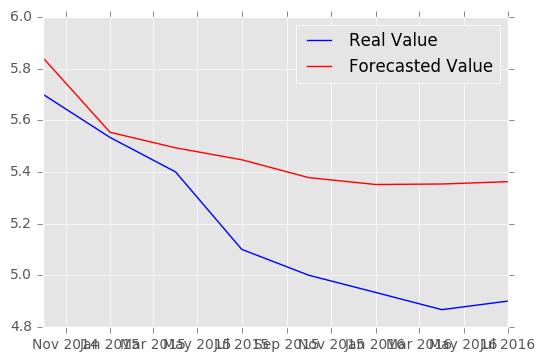

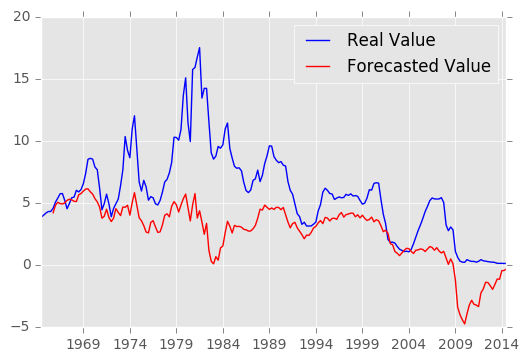

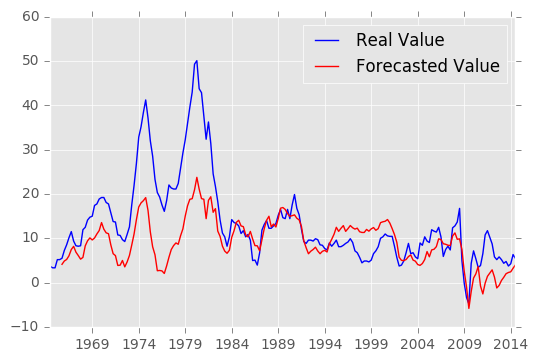

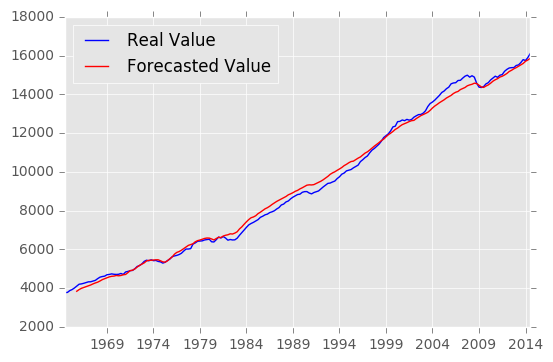

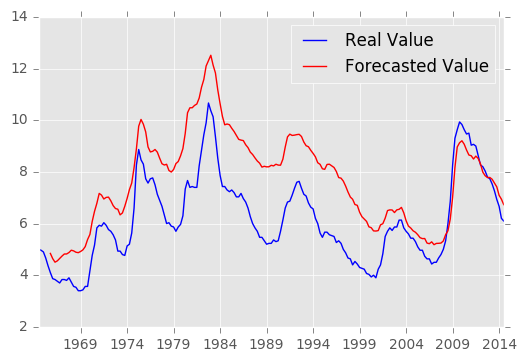

In [46]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
print(error(var_undiff_out['umpr'], test_real['umpr']))

plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])

plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

# Hybrid

In [47]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

С DropOut

In [48]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(N_FEAT, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=50, period='q')

Epoch 1/50
1s - loss: 1.1509
Epoch 2/50
0s - loss: 1.0295
Epoch 3/50
0s - loss: 1.0111
Epoch 4/50
0s - loss: 1.0113
Epoch 5/50
0s - loss: 1.0065
Epoch 6/50
0s - loss: 1.0174
Epoch 7/50
0s - loss: 1.0181
Epoch 8/50
0s - loss: 1.0096
Epoch 9/50
0s - loss: 1.0064
Epoch 10/50
0s - loss: 1.0101
Epoch 11/50
0s - loss: 1.0014
Epoch 12/50
0s - loss: 1.0049
Epoch 13/50
0s - loss: 0.9968
Epoch 14/50
0s - loss: 1.0046
Epoch 15/50
0s - loss: 1.0091
Epoch 16/50
0s - loss: 1.0019
Epoch 17/50
0s - loss: 1.0076
Epoch 18/50
0s - loss: 1.0057
Epoch 19/50
0s - loss: 0.9996
Epoch 20/50
0s - loss: 1.0010
Epoch 21/50
0s - loss: 1.0010
Epoch 22/50
0s - loss: 1.0052
Epoch 23/50
0s - loss: 1.0071
Epoch 24/50
0s - loss: 1.0000
Epoch 25/50
0s - loss: 1.0007
Epoch 26/50
0s - loss: 1.0024
Epoch 27/50
0s - loss: 1.0007
Epoch 28/50
0s - loss: 0.9974
Epoch 29/50
0s - loss: 0.9999
Epoch 30/50
0s - loss: 1.0008
Epoch 31/50
0s - loss: 1.0000
Epoch 32/50
0s - loss: 0.9999
Epoch 33/50
0s - loss: 0.9999
Epoch 34/50
0s - lo

{'mse': 0.41192562657040488, 'rmse': 0.64181432406141026, 'mae': 0.53205466124806333}
{'mse': 36.484886711047579, 'rmse': 6.040272072601331, 'mae': 5.778140411985909}
{'mse': 1202.1714467519062, 'rmse': 34.672344119656898, 'mae': 30.087377952915631}
{'mse': 0.096244229977952109, 'rmse': 0.31023254177786075, 'mae': 0.26743818450984835}


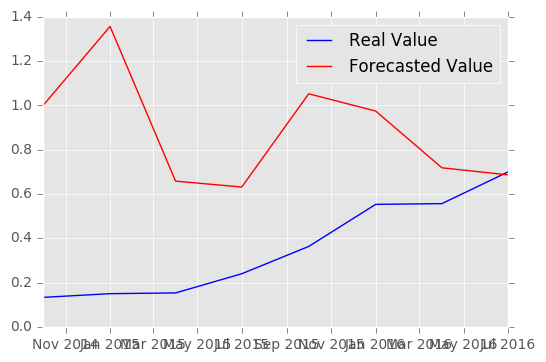

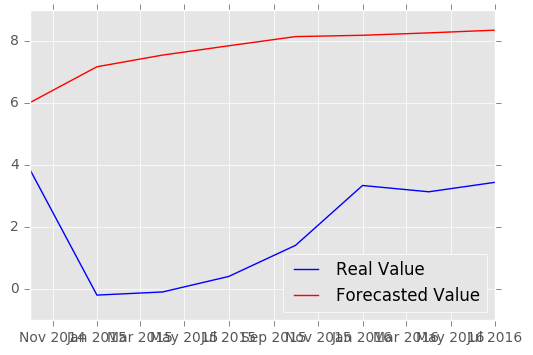

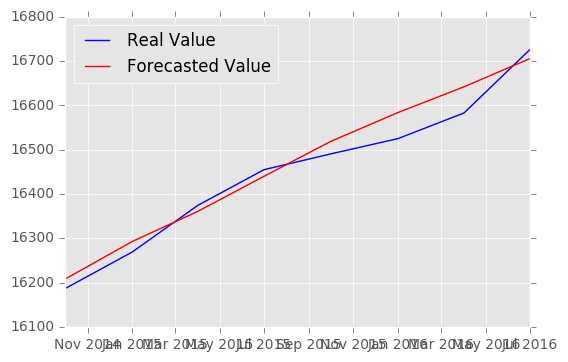

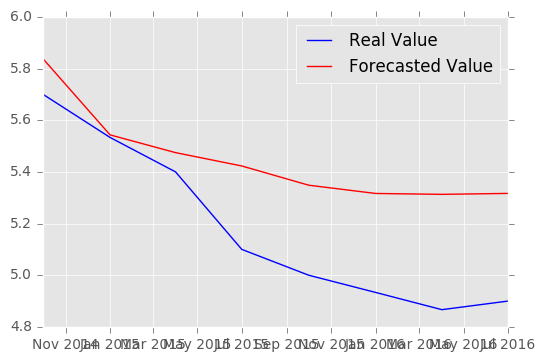

In [49]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))

plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])